# Install Required Packages

In [1]:
!pip install scikit-learn xgboost lightgbm joblib matplotlib seaborn

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
import xgboost as xgb
import lightgbm as lgb
import joblib
from scipy.stats import skew, kurtosis
from sklearn.metrics import classification_report


# Load the Data

## About the CSV Files
- `timed_df.csv` contains data for all states **except State 13**.
- `baseline_timed.csv` contains data **only for State 13**.


In [3]:
# Load both CSV files
damaged_df = pd.read_csv("timed_df.csv")
undamaged_df = pd.read_csv("baseline_timed.csv")

# Add labels: 1 for damaged, 0 for undamaged
damaged_df['label'] = 1
undamaged_df['label'] = 0

# Combine the datasets
df = pd.concat([damaged_df, undamaged_df], ignore_index=True)

print(" Combined data shape:", df.shape)
df.head()


 Combined data shape: (1384448, 9)


,Unnamed: 0,Time,Force Transducer,Accelerometer 1,Accelerometer 2,Accelerometer 3,Accelerometer 4,State,label
0,0,0.0000,15.66710,0.435170,0.041358,-0.179954,0.049033,1,1
1,1,0.0031,12.42760,-0.030668,0.096704,0.786429,-0.666803,1,1
2,2,0.0062,19.51020,-0.238181,0.400636,0.713335,-0.714454,1,1
3,3,0.0093,-1.35914,-0.412437,0.554442,-0.207911,-0.118673,1,1
4,4,0.0124,-16.37290,0.024085,-0.012602,-0.730537,0.469126,1,1


In [4]:
df = df.drop(columns='Unnamed: 0')

In [5]:
df.tail()

,Time,Force Transducer,Accelerometer 1,Accelerometer 2,Accelerometer 3,Accelerometer 4,State,label
1384443,25.3797,12.45580,-0.014923,0.321787,-0.191577,0.065088,13,0
1384444,25.3828,13.51050,-0.035722,0.398182,-0.069455,-0.036084,13,0
1384445,25.3859,-5.78412,-0.153932,0.016242,0.270518,-0.148715,13,0
1384446,25.3890,-10.72720,0.019040,-0.307571,0.280888,-0.061137,13,0
1384447,25.3921,-9.99747,0.110564,-0.169768,-0.139877,0.179321,13,0


In [16]:
df.describe()

,Time,Force Transducer,Accelerometer 1,Accelerometer 2,Accelerometer 3,Accelerometer 4,State,label
count,1.384448e+06,1.384448e+06,1.384448e+06,1.384448e+06,1.384448e+06,1.384448e+06,1.384448e+06,1.384448e+06
mean,1.269605e+01,2.197301e-03,1.694454e-05,1.290014e-05,5.647303e-06,-2.856201e-06,1.388757e+01,9.467456e-01
std,7.330965e+00,2.028919e+01,5.037546e-01,5.142362e-01,4.674523e-01,3.780598e-01,6.561890e+00,2.245405e-01
min,0.000000e+00,-8.470480e+01,-2.522589e+00,-2.706371e+00,-2.655637e+00,-2.354332e+00,1.000000e+00,0.000000e+00
25%,6.348025e+00,-1.377820e+01,-3.414692e-01,-3.426804e-01,-3.139661e-01,-2.470943e-01,1.000000e+01,1.000000e+00
50%,1.269605e+01,1.917080e-02,-8.790785e-04,-7.830046e-04,-4.471371e-03,3.782115e-03,1.400000e+01,1.000000e+00
75%,1.904407e+01,1.376050e+01,3.402543e-01,3.426957e-01,3.084559e-01,2.529837e-01,1.800000e+01,1.000000e+00
max,2.539210e+01,8.806910e+01,2.269154e+00,2.762334e+00,2.448522e+00,1.826239e+00,2.400000e+01,1.000000e+00


<Axes: >

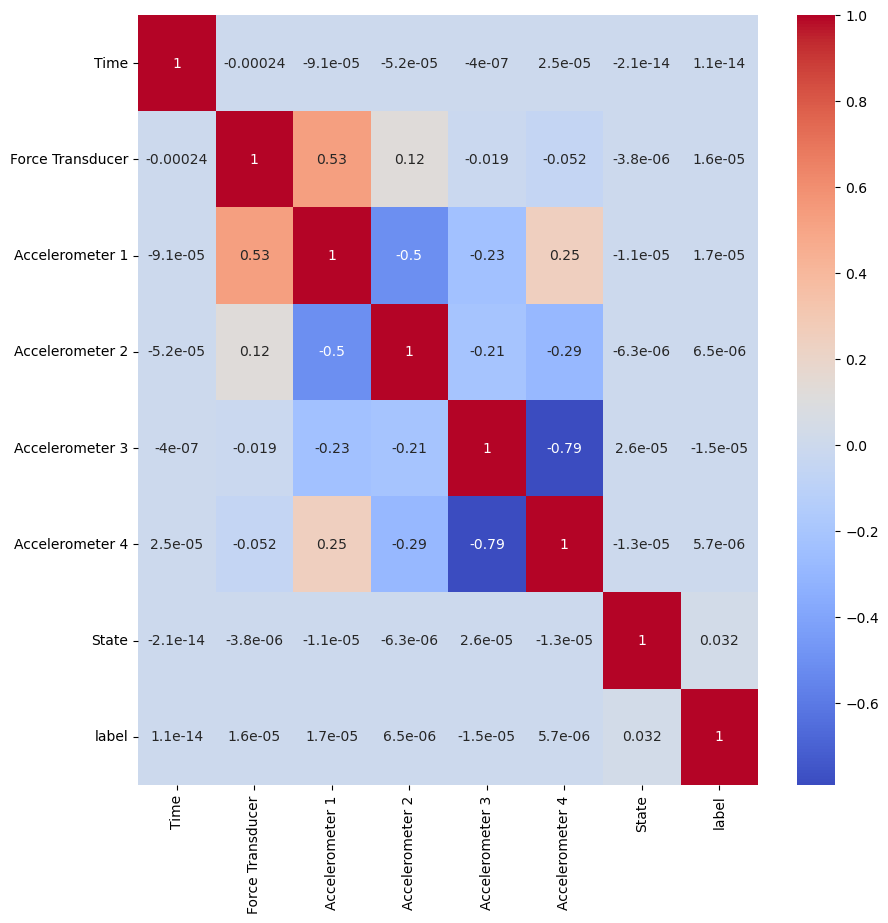

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')

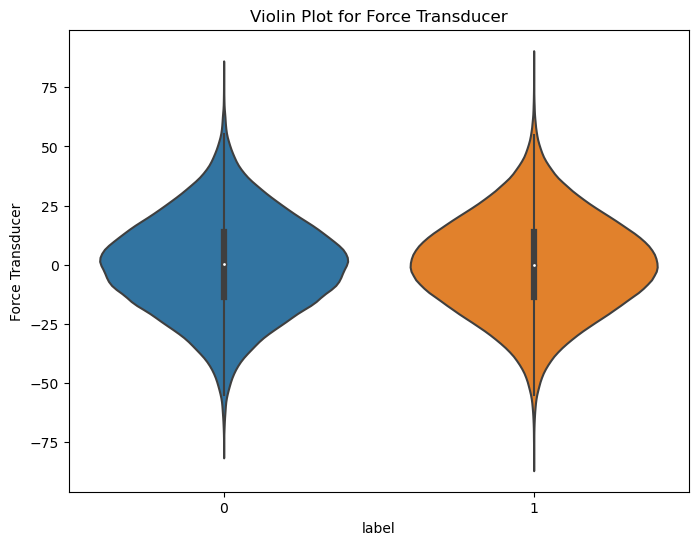

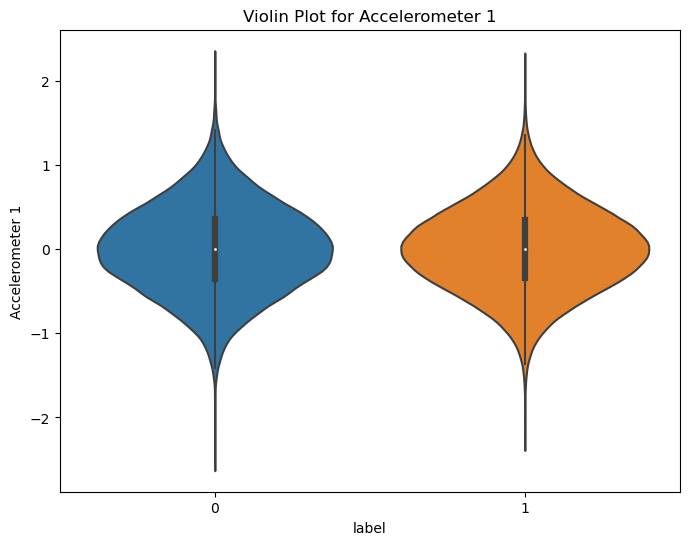

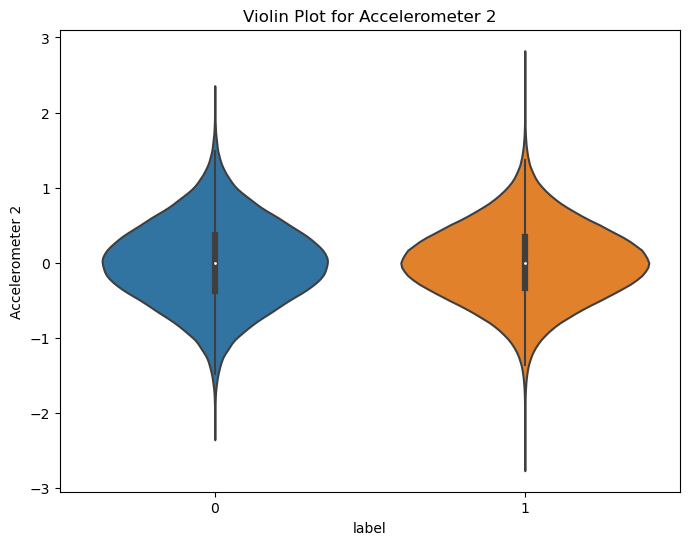

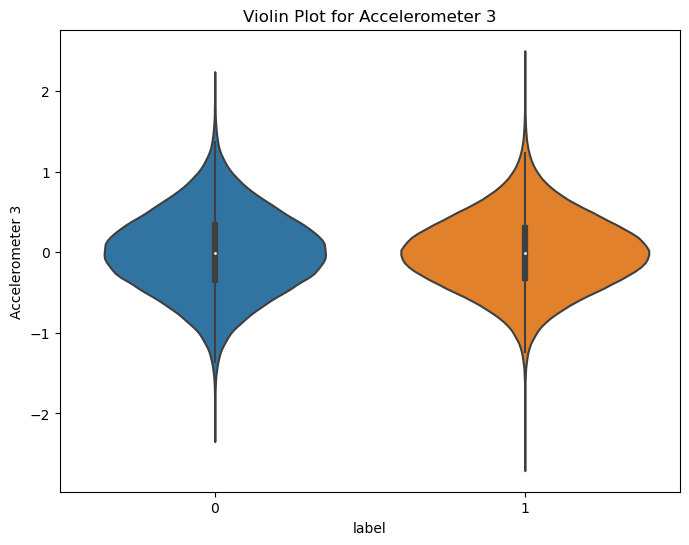

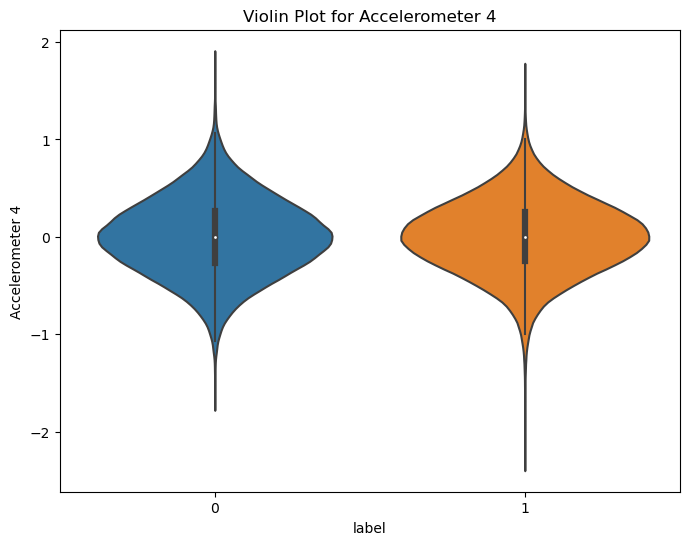

In [15]:
# Assuming 'df' is your DataFrame and 'Label' is the target column
for column in df.columns:
    if column != 'label' and column!='Time' and column!='State':  # Skip the target column if it's categorical
        plt.figure(figsize=(8, 6))
        sns.violinplot(x='label', y=column, data=df)
        plt.title(f'Violin Plot for {column}')
        plt.xlabel('label')
        plt.ylabel(column)
        plt.show()

# Group by State + Timestamp & Extract Features

In [6]:
def extract_optimal_features(df):
    feature_rows = []
    
    sensors = ['Force Transducer', 'Accelerometer 1', 'Accelerometer 2', 'Accelerometer 3', 'Accelerometer 4']
    
    for (state, time), group in df.groupby(['State', 'Time']):
        row = {'State': state, 'Time': time, 'Label': group['label'].iloc[0]}
        
        for sensor in sensors:
            signal = group[sensor].values

            row[f'{sensor}_mean'] = np.mean(signal)
            row[f'{sensor}_std'] = np.std(signal)
            row[f'{sensor}_min'] = np.min(signal)
            row[f'{sensor}_max'] = np.max(signal)
            row[f'{sensor}_rms'] = np.sqrt(np.mean(signal**2))
            row[f'{sensor}_ptp'] = np.ptp(signal)
            row[f'{sensor}_skew'] = skew(signal)
            row[f'{sensor}_kurtosis'] = kurtosis(signal)
            row[f'{sensor}_energy'] = np.sum(signal**2)
            row[f'{sensor}_zcr'] = ((signal[:-1] * signal[1:]) < 0).sum()

        feature_rows.append(row)
    
    features_df = pd.DataFrame(feature_rows)
    return features_df

In [7]:
features_df = extract_optimal_features(df)
print(" Features shape:", features_df.shape)
features_df.head()

 Features shape: (139264, 53)


,State,Time,Label,Force Transducer_mean,Force Transducer_std,Force Transducer_min,Force Transducer_max,Force Transducer_rms,Force Transducer_ptp,Force Transducer_skew,...,Accelerometer 4_mean,Accelerometer 4_std,Accelerometer 4_min,Accelerometer 4_max,Accelerometer 4_rms,Accelerometer 4_ptp,Accelerometer 4_skew,Accelerometer 4_kurtosis,Accelerometer 4_energy,Accelerometer 4_zcr
0,1,0.0000,1,23.932270,7.779465,13.6041,39.3699,25.164928,25.7658,0.599033,...,-0.084762,0.200688,-0.428784,0.256291,0.217854,0.685074,-0.087884,-0.650274,0.474604,2
1,1,0.0031,1,1.841594,8.554617,-13.7296,17.5841,8.750596,31.3137,0.182220,...,-0.013274,0.331440,-0.666803,0.384130,0.331706,1.050934,-0.583245,-0.765956,1.100290,7
2,1,0.0062,1,-5.654653,21.650357,-44.8649,27.1869,22.376618,72.0518,-0.055037,...,0.013142,0.358713,-0.714454,0.456393,0.358954,1.170847,-0.605309,-0.662557,1.288480,4
3,1,0.0093,1,3.745189,14.699810,-15.0212,26.9011,15.169405,41.9223,0.139607,...,0.019229,0.271213,-0.515829,0.533473,0.271894,1.049302,0.065455,0.030262,0.739264,6
4,1,0.0124,1,-2.398134,14.675826,-19.2963,24.6721,14.870471,43.9684,0.676452,...,0.093308,0.234289,-0.246996,0.469126,0.252186,0.716122,0.228618,-1.263337,0.635977,5


In [9]:
features_df.shape

(139264, 53)

In [10]:
X = features_df.drop(columns=['State', 'Time', 'Label'])
y = features_df['Label']

In [11]:
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (139264, 50)
Labels shape: (139264,)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (111411, 50) Test shape: (27853, 50)


In [16]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}


Training Random Forest...
CV F1 (mean ± std): 0.974 ± 0.000
CV AUC (mean ± std): 0.995 ± 0.001
CV Accuracy (mean ± std): 0.950 ± 0.001
Test Accuracy: 0.954 | Test F1: 0.976 | Test AUC: 0.996
              precision    recall  f1-score   support

           0       1.00      0.22      0.36      1638
           1       0.95      1.00      0.98     26215

    accuracy                           0.95     27853
   macro avg       0.98      0.61      0.67     27853
weighted avg       0.96      0.95      0.94     27853



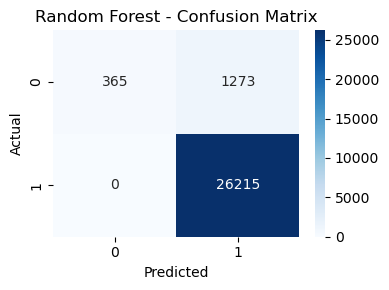


Training XGBoost...


/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:19:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:19:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:19:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:19:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "

CV F1 (mean ± std): 1.000 ± 0.000
CV AUC (mean ± std): 1.000 ± 0.000
CV Accuracy (mean ± std): 1.000 ± 0.000
Test Accuracy: 1.000 | Test F1: 1.000 | Test AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1638
           1       1.00      1.00      1.00     26215

    accuracy                           1.00     27853
   macro avg       1.00      1.00      1.00     27853
weighted avg       1.00      1.00      1.00     27853



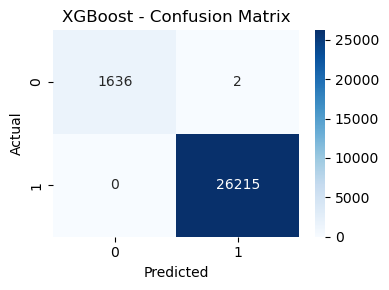


Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 104857, number of negative: 6554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11525
[LightGBM] [Info] Number of data points in the train set: 111411, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941173 -> initscore=2.772522
[LightGBM] [Info] Start training from score 2.772522
CV F1 (mean ± std): 1.000 ± 0.000
CV AUC (mean ± std): 1.000 ± 0.000
CV Accuracy (mean ± std): 1.000 ± 0.000
Test Accuracy: 1.000 | Test F1: 1.000 | Test AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1638
           1       1.00      1.00      1.00     26215

    accuracy                           1.00     27853
   macro avg       1.

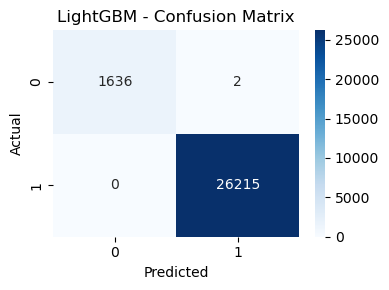


Training Logistic Regression...
CV F1 (mean ± std): 0.995 ± 0.000
CV AUC (mean ± std): 0.978 ± 0.005
CV Accuracy (mean ± std): 0.991 ± 0.000
Test Accuracy: 0.991 | Test F1: 0.995 | Test AUC: 0.976
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1638
           1       0.99      1.00      1.00     26215

    accuracy                           0.99     27853
   macro avg       0.99      0.93      0.96     27853
weighted avg       0.99      0.99      0.99     27853



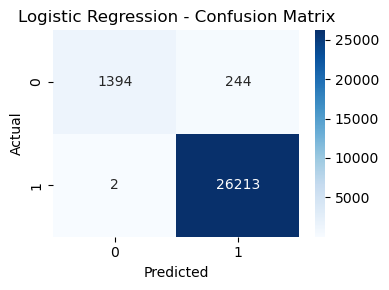


Training MLP...
CV F1 (mean ± std): 1.000 ± 0.000
CV AUC (mean ± std): 1.000 ± 0.001
CV Accuracy (mean ± std): 0.999 ± 0.001
Test Accuracy: 0.999 | Test F1: 1.000 | Test AUC: 1.000
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1638
           1       1.00      1.00      1.00     26215

    accuracy                           1.00     27853
   macro avg       1.00      1.00      1.00     27853
weighted avg       1.00      1.00      1.00     27853



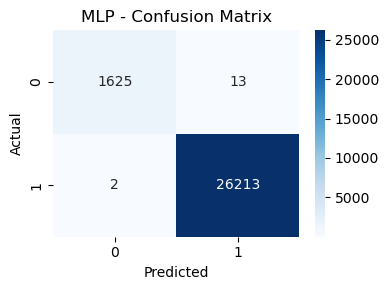

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

results = []
roc_curves = []

colors = sns.color_palette("husl", len(models))  
trained_models = {}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scorers for cross-validation
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

for idx, (name, model) in enumerate(models.items()):
    print(f"\nTraining {name}...")

    # Choose data based on model type
    if name in ['Logistic Regression', 'SVM', 'MLP']:
        X_train_data, X_test_data = X_train_scaled, X_test_scaled
    else:
        X_train_data, X_test_data = X_train, X_test

    # Cross-validation
    cv_scores = cross_validate(
        model, X_train_data, y_train, cv=skf, scoring=scoring, n_jobs=-1
    )

    # Train on full training set
    model.fit(X_train_data, y_train)

    # Predict on test set
    y_pred = model.predict(X_test_data)
    y_proba = model.predict_proba(X_test_data)[:, 1]

    # Test set metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"CV F1 (mean ± std): {cv_scores['test_f1'].mean():.3f} ± {cv_scores['test_f1'].std():.3f}")
    print(f"CV AUC (mean ± std): {cv_scores['test_roc_auc'].mean():.3f} ± {cv_scores['test_roc_auc'].std():.3f}")
    print(f"CV Accuracy (mean ± std): {cv_scores['test_accuracy'].mean():.3f} ± {cv_scores['test_accuracy'].std():.3f}")
    print(f"Test Accuracy: {acc:.3f} | Test F1: {f1:.3f} | Test AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC curve info
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves.append((fpr, tpr, auc, name))

    # Save results
    results.append({
        'Model': name,
        'CV_F1_Mean': cv_scores['test_f1'].mean(),
        'CV_F1_Std': cv_scores['test_f1'].std(),
        'CV_AUC_Mean': cv_scores['test_roc_auc'].mean(),
        'CV_AUC_Std': cv_scores['test_roc_auc'].std(),
        'CV_Accuracy_Mean': cv_scores['test_accuracy'].mean(),
        'CV_Accuracy_Std': cv_scores['test_accuracy'].std(),
        'Test_Accuracy': acc,
        'Test_F1': f1,
        'Test_AUC': auc
    })

    # Store trained model
    trained_models[name] = model


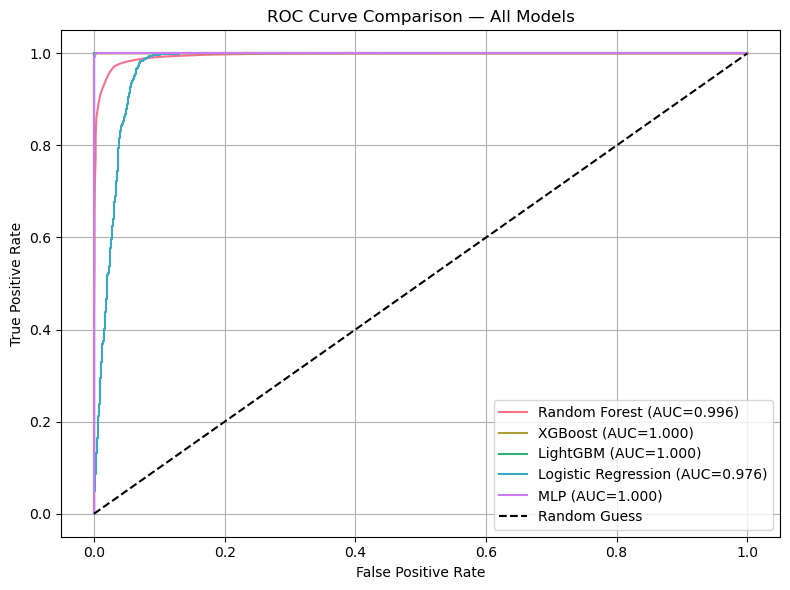

In [25]:
# Final ROC Curve Plot
plt.figure(figsize=(8, 6))
for idx, (fpr, tpr, auc, name) in enumerate(roc_curves):
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison — All Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
results_df = pd.DataFrame(results).sort_values(by='Test_F1', ascending=False)
print("\n📊 Final Model Performance Summary:")
results_df


📊 Final Model Performance Summary:


,Model,CV_F1_Mean,CV_F1_Std,CV_AUC_Mean,CV_AUC_Std,CV_Accuracy_Mean,CV_Accuracy_Std,Test_Accuracy,Test_F1,Test_AUC
1,XGBoost,0.999938,0.000036,1.000000,1.454917e-08,0.999883,0.000067,0.999928,0.999962,1.000000
2,LightGBM,0.999967,0.000012,1.000000,0.000000e+00,0.999937,0.000022,0.999928,0.999962,1.000000
4,MLP,0.999681,0.000314,0.999502,6.180839e-04,0.999399,0.000591,0.999461,0.999714,0.999956
3,Logistic Regression,0.995075,0.000140,0.977631,4.802102e-03,0.990683,0.000267,0.991168,0.995330,0.975745
0,Random Forest,0.974344,0.000473,0.994748,9.047127e-04,0.950436,0.000938,0.954296,0.976296,0.995504


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 83885, number of negative: 5243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11525
[LightGBM] [Info] Number of data points in the train set: 89128, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941174 -> initscore=2.772553
[LightGBM] [Info] Start training from score 2.772553
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 83886, number of negative: 5243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11525
[LightGBM] [Info] Number of data points in the train set: 89129, number of used f

In [23]:
# # Save best model as pickle based on highest AUC
# best_model_info = max(results, key=lambda x: x['Test_AUC'])
# best_model_name = best_model_info['Model']
# best_model = trained_models[best_model_name]

# # Save best model to .pkl
# with open(f"{best_model_name.replace(' ', '_').lower()}_best_model.pkl", "wb") as f:
#     pickle.dump(best_model, f)

# print(f"\n Best model '{best_model_name}' saved as: {best_model_name.replace(' ', '_').lower()}_best_model2.pkl")

KeyError: 'AUC'

# APPROACH 2

In [27]:
features_df.head()

,State,Time,Label,Force Transducer_mean,Force Transducer_std,Force Transducer_min,Force Transducer_max,Force Transducer_rms,Force Transducer_ptp,Force Transducer_skew,...,Accelerometer 4_mean,Accelerometer 4_std,Accelerometer 4_min,Accelerometer 4_max,Accelerometer 4_rms,Accelerometer 4_ptp,Accelerometer 4_skew,Accelerometer 4_kurtosis,Accelerometer 4_energy,Accelerometer 4_zcr
0,1,0.0000,1,23.932270,7.779465,13.6041,39.3699,25.164928,25.7658,0.599033,...,-0.084762,0.200688,-0.428784,0.256291,0.217854,0.685074,-0.087884,-0.650274,0.474604,2
1,1,0.0031,1,1.841594,8.554617,-13.7296,17.5841,8.750596,31.3137,0.182220,...,-0.013274,0.331440,-0.666803,0.384130,0.331706,1.050934,-0.583245,-0.765956,1.100290,7
2,1,0.0062,1,-5.654653,21.650357,-44.8649,27.1869,22.376618,72.0518,-0.055037,...,0.013142,0.358713,-0.714454,0.456393,0.358954,1.170847,-0.605309,-0.662557,1.288480,4
3,1,0.0093,1,3.745189,14.699810,-15.0212,26.9011,15.169405,41.9223,0.139607,...,0.019229,0.271213,-0.515829,0.533473,0.271894,1.049302,0.065455,0.030262,0.739264,6
4,1,0.0124,1,-2.398134,14.675826,-19.2963,24.6721,14.870471,43.9684,0.676452,...,0.093308,0.234289,-0.246996,0.469126,0.252186,0.716122,0.228618,-1.263337,0.635977,5


In [42]:
cols_to_include = ['State', 'Time', 'Label','Force Transducer_mean', 'Accelerometer 1_mean', 'Accelerometer 2_mean', 'Accelerometer 3_mean','Accelerometer 4_mean', 'Force Transducer_std', ]
new_df = features_df[cols_to_include].copy()

In [43]:
new_df.head()

,State,Time,Label,Force Transducer_mean,Accelerometer 1_mean,Accelerometer 2_mean,Accelerometer 3_mean,Accelerometer 4_mean
0,1,0.0000,1,23.932270,0.407228,-0.022722,0.073665,-0.084762
1,1,0.0031,1,1.841594,-0.205250,0.234931,-0.045812,-0.013274
2,1,0.0062,1,-5.654653,-0.345675,0.196237,-0.027984,0.013142
3,1,0.0093,1,3.745189,0.042122,-0.152973,0.103451,0.019229
4,1,0.0124,1,-2.398134,0.113780,-0.316567,0.075783,0.093308


In [44]:
X2 = new_df.drop(columns=['State', 'Time', 'Label'])
y2 = new_df['Label']

In [45]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, stratify=y2, test_size=0.2, random_state=42
)

print("Train shape:", X_train2.shape, "Test shape:", X_test2.shape)


Train shape: (111411, 5) Test shape: (27853, 5)


In [46]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)


Training Random Forest...
CV F1 (mean ± std): 0.970 ± 0.000
CV AUC (mean ± std): 0.536 ± 0.006
CV Accuracy (mean ± std): 0.941 ± 0.000
Test Accuracy: 0.941 | Test F1: 0.970 | Test AUC: 0.535
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1638
           1       0.94      1.00      0.97     26215

    accuracy                           0.94     27853
   macro avg       0.47      0.50      0.48     27853
weighted avg       0.89      0.94      0.91     27853



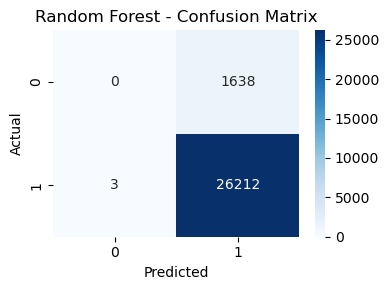


Training XGBoost...


/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:55:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "

CV F1 (mean ± std): 0.970 ± 0.000
CV AUC (mean ± std): 0.525 ± 0.005
CV Accuracy (mean ± std): 0.941 ± 0.000
Test Accuracy: 0.941 | Test F1: 0.970 | Test AUC: 0.545
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1638
           1       0.94      1.00      0.97     26215

    accuracy                           0.94     27853
   macro avg       0.47      0.50      0.48     27853
weighted avg       0.89      0.94      0.91     27853



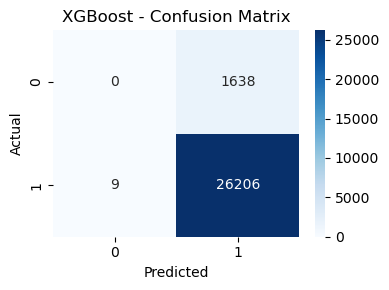


Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 104857, number of negative: 6554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 111411, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941173 -> initscore=2.772522
[LightGBM] [Info] Start training from score 2.772522
CV F1 (mean ± std): 0.970 ± 0.000
CV AUC (mean ± std): 0.562 ± 0.006
CV Accuracy (mean ± std): 0.941 ± 0.000
Test Accuracy: 0.941 | Test F1: 0.970 | Test AUC: 0.571
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1638
           1       0.94      1.00      0.97     26215

    accuracy 

/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


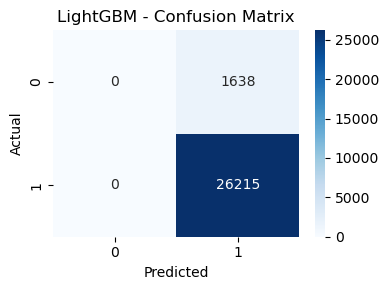


Training Logistic Regression...
CV F1 (mean ± std): 0.970 ± 0.000
CV AUC (mean ± std): 0.493 ± 0.004
CV Accuracy (mean ± std): 0.941 ± 0.000
Test Accuracy: 0.941 | Test F1: 0.970 | Test AUC: 0.480
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1638
           1       0.94      1.00      0.97     26215

    accuracy                           0.94     27853
   macro avg       0.47      0.50      0.48     27853
weighted avg       0.89      0.94      0.91     27853



/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


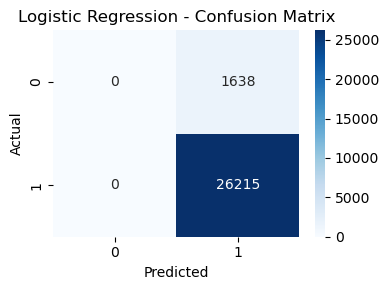


Training MLP...
CV F1 (mean ± std): 0.970 ± 0.000
CV AUC (mean ± std): 0.574 ± 0.005
CV Accuracy (mean ± std): 0.941 ± 0.000
Test Accuracy: 0.941 | Test F1: 0.970 | Test AUC: 0.581
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1638
           1       0.94      1.00      0.97     26215

    accuracy                           0.94     27853
   macro avg       0.47      0.50      0.48     27853
weighted avg       0.89      0.94      0.91     27853



/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shashipreetham/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


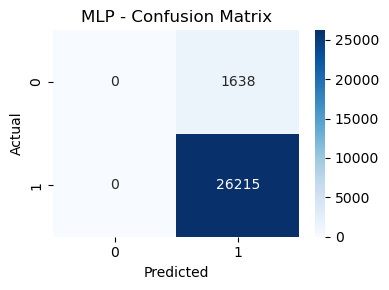

In [47]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

results2 = []
roc_curves2 = []

colors = sns.color_palette("husl", len(models))  # one color per model
trained_models2 = {}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scorers for cross-validation
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy'
}

for idx, (name, model) in enumerate(models.items()):
    print(f"\nTraining {name}...")

    # Choose data based on model type
    if name in ['Logistic Regression', 'SVM', 'MLP']:
        X_train_data2, X_test_data2 = X_train_scaled2, X_test_scaled2
    else:
        X_train_data2, X_test_data2 = X_train2, X_test2

    # Cross-validation
    cv_scores2 = cross_validate(
        model, X_train_data2, y_train2, cv=skf, scoring=scoring, n_jobs=-1
    )

    # Train on full training set
    model.fit(X_train_data2, y_train2)

    # Predict on test set
    y_pred2 = model.predict(X_test_data2)
    y_proba2 = model.predict_proba(X_test_data2)[:, 1]

    # Test set metrics
    acc = accuracy_score(y_test2, y_pred2)
    f1 = f1_score(y_test2, y_pred2)
    auc = roc_auc_score(y_test2, y_proba2)

    print(f"CV F1 (mean ± std): {cv_scores2['test_f1'].mean():.3f} ± {cv_scores2['test_f1'].std():.3f}")
    print(f"CV AUC (mean ± std): {cv_scores2['test_roc_auc'].mean():.3f} ± {cv_scores2['test_roc_auc'].std():.3f}")
    print(f"CV Accuracy (mean ± std): {cv_scores2['test_accuracy'].mean():.3f} ± {cv_scores2['test_accuracy'].std():.3f}")
    print(f"Test Accuracy: {acc:.3f} | Test F1: {f1:.3f} | Test AUC: {auc:.3f}")
    print(classification_report(y_test2, y_pred2))

    # Confusion Matrix
    conf = confusion_matrix(y_test2, y_pred2)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC curve info
    fpr, tpr, _ = roc_curve(y_test2, y_proba2)
    roc_curves2.append((fpr, tpr, auc, name))

    # Save results
    results2.append({
        'Model': name,
        'CV_F1_Mean': cv_scores2['test_f1'].mean(),
        'CV_F1_Std': cv_scores2['test_f1'].std(),
        'CV_AUC_Mean': cv_scores2['test_roc_auc'].mean(),
        'CV_AUC_Std': cv_scores2['test_roc_auc'].std(),
        'CV_Accuracy_Mean': cv_scores2['test_accuracy'].mean(),
        'CV_Accuracy_Std': cv_scores2['test_accuracy'].std(),
        'Test_Accuracy': acc,
        'Test_F1': f1,
        'Test_AUC': auc
    })

    # Store trained model
    trained_models2[name] = model


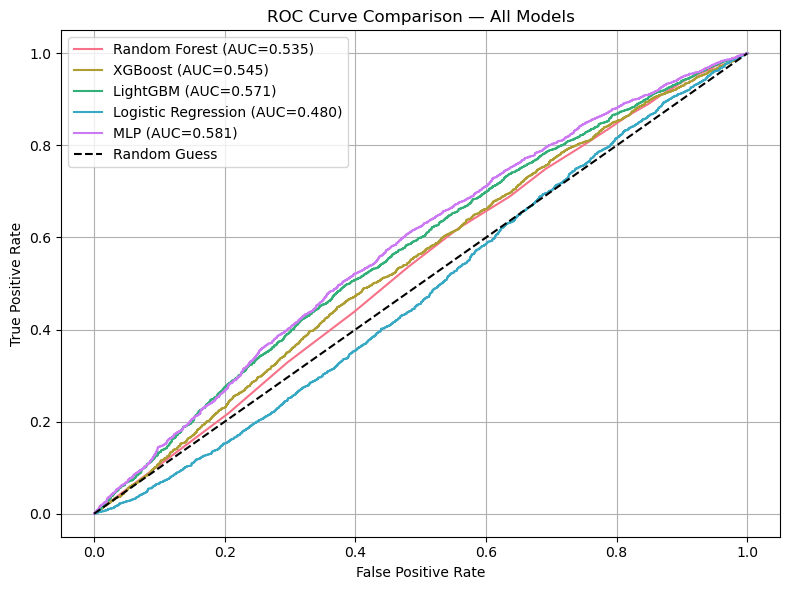

In [48]:
# Final ROC Curve Plot
plt.figure(figsize=(8, 6))
for idx, (fpr, tpr, auc, name) in enumerate(roc_curves2):
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison — All Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
results_df2 = pd.DataFrame(results2).sort_values(by='Test_F1', ascending=False)
print("\n Final Model Performance Summary:")
results_df2


 Final Model Performance Summary:


,Model,CV_F1_Mean,CV_F1_Std,CV_AUC_Mean,CV_AUC_Std,CV_Accuracy_Mean,CV_Accuracy_Std,Test_Accuracy,Test_F1,Test_AUC
2,LightGBM,0.969685,0.000018,0.562481,0.006211,0.941155,0.000033,0.941191,0.969705,0.571122
3,Logistic Regression,0.969695,0.000009,0.493359,0.004135,0.941173,0.000018,0.941191,0.969705,0.479978
4,MLP,0.969690,0.000015,0.573910,0.004813,0.941164,0.000028,0.941191,0.969705,0.581136
0,Random Forest,0.969637,0.000038,0.536191,0.006489,0.941065,0.000073,0.941084,0.969648,0.535093
1,XGBoost,0.969509,0.000042,0.524695,0.004926,0.940823,0.000078,0.940868,0.969533,0.544928
